In [1]:
%%bash
pip install gensim
pip install emoji --no-deps


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


## Import Libraries

In [2]:
import re
import string
import emoji
import pandas as pd
import nltk
import stopwordsiso
from bs4 import BeautifulSoup

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import pandas as pd
from sklearn.utils import resample
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, precision_recall_curve
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import svm
from stopwordsiso import stopwords
import pickle
import time

import torch
from transformers import BertModel, BertTokenizer
import gc
from transformers import (
    BertTokenizer, BertModel,
    RobertaTokenizer, RobertaModel,
    DistilBertTokenizer, DistilBertModel
)

from sklearn.model_selection import train_test_split
import re
import os
import requests
import gc
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sarfrazahmad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sarfrazahmad/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sarfrazahmad/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Read Data

In [3]:
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
train_path = os.path.join(BASE_DIR, 'Dataset', 'english_dataset', 'english_dataset.tsv')
test_path = os.path.join(BASE_DIR, 'Dataset', 'english_dataset', 'hasoc2019_en_test-2919.tsv')

In [5]:
train = pd.read_csv(train_path, sep='\t')
test = pd.read_csv(test_path, sep='\t')

train.drop(["text_id", 'task_2', 'task_3'], axis=1, inplace=True)
test.drop(["text_id", 'task_2', 'task_3'], axis=1, inplace=True)

# rename task_1 to label
train.rename(columns={'task_1': 'label'}, inplace=True)
test.rename(columns={'task_1': 'label'}, inplace=True)

# Map the labels to integers
label_map = {'HOF': 1, 'NOT': 0}

train['label'] = train['label'].map(label_map)
test['label'] = test['label'].map(label_map)

In [6]:
train.shape, test.shape

((5852, 2), (1153, 2))

## Data Pre-processing

In [7]:
# Data Cleaning

# Contraction Mapping: Map commonly used contractions to their expanded forms
# This helps normalize text and makes it easier to process later.
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", 
                       "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", 
                       "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
                       "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am",
                       "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", 
                       "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                       "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not",
                       "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", 
                       "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                       "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", 
                       "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                       "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is",
                       "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would",
                       "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
                       "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                       "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", 
                       "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
                       "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", 
                       "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                       "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have",
                       "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'u.s':'america', 'e.g':'for example'}

# Punctuation List: Common punctuation symbols to identify and process in text
punct = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

# Punctuation Mapping: Map specific punctuation to replacements for normalization
punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-",
                 "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 
                 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', '!':' '}

# Misspelling Dictionary: Map common misspellings to their correct spellings
mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater',
                'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ',
                'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can',
                'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 
                'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 
                'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 
                'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization',
                'demonetisation': 'demonetization'}

In [8]:
def clean_text(text):
    '''Clean emoji, Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''

    # Remove User Mentions
    text = re.sub(r'@\w+\s*', '', text)

    # Remove Hashtags
    text = re.sub(r'#\w+', '', text)

    # Convert emojis to demojized text if emojis exist
    if any(char in emoji.EMOJI_DATA for char in text):
        text = emoji.demojize(text)

    # Remove only emoji placeholders (not all colon-enclosed text)
    text = re.sub(r'\:[a-zA-Z0-9_]+\:', '', text)

    text = str(text).lower()    #Making Text Lowercase
    text = re.sub('\[.*?\]', '', text)
    #The next 2 lines remove html text

    text = BeautifulSoup(text, 'lxml').get_text()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",", "'")
    text = re.sub(r"[^a-zA-Z?.!,¿']+", " ", text)
    return text

def clean_contractions(text, mapping):
    '''Clean contraction using contraction mapping'''    
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    for word in mapping.keys():
        if ""+word+"" in text:
            text = text.replace(""+word+"", ""+mapping[word]+"")
    #Remove Punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    text = re.sub(r"([?.!,¿])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text)
    return text

def clean_special_chars(text, punct, mapping):
    '''Cleans special characters present(if any)'''   
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}  
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text

def correct_spelling(x, dic):
    '''Corrects common spelling errors'''   
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

def remove_space(text):
    '''Removes awkward spaces'''   
    #Removes awkward spaces 
    text = text.strip()
    text = text.split()
    return " ".join(text)

def text_preprocessing_pipeline(text):
    '''Cleaning and parsing the text.'''
    text = clean_text(text)
    text = clean_contractions(text, contraction_mapping)
    text = clean_special_chars(text, punct, punct_mapping)
    text = correct_spelling(text, mispell_dict)
    text = remove_space(text)
    return text

In [9]:
%%time
# Pre-processing
train['text'] = train['text'].apply(text_preprocessing_pipeline)
test['text'] = test['text'].apply(text_preprocessing_pipeline)

CPU times: user 847 ms, sys: 16.5 ms, total: 863 ms
Wall time: 869 ms


In [10]:
train.head()

,text,label
0,watch sports minister kiren rijiju issues stat...,0
1,no we should remember very clearly that just a...,1
2,guess who would be the winner of this team who...,0
3,corbyn is too politically intellectual for can...,0
4,all the best to for another swimming competiti...,0


In [11]:
test.head()

,text,label
0,west bengal doctor crisis protesting doctors a...,0
1,million people have been forced to leave their...,0
2,you came you saw we will look after the fort g...,0
3,we will get brexit delivered by october help b...,0
4,fuck you go back to the dark ages you cow rape...,1


## Traditional Machine Learning Models

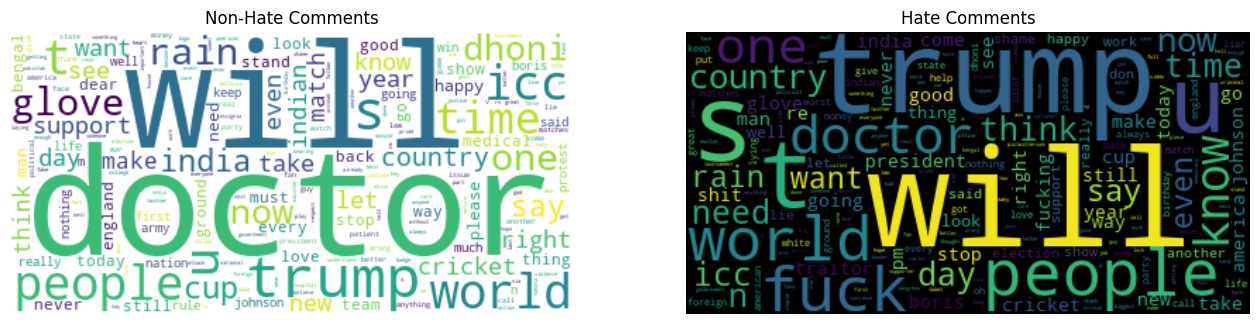

In [12]:
fig, axs = plt.subplots(1,2 , figsize=(16,8))
text_pos = " ".join(train['text'][train.label == 0])
text_neg = " ".join(train['text'][train.label == 1])
train_cloud_pos = WordCloud(collocations = False, background_color = 'white').generate(text_pos)
train_cloud_neg = WordCloud(collocations = False, background_color = 'black').generate(text_neg)
axs[0].imshow(train_cloud_pos, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title('Non-Hate Comments')
axs[1].imshow(train_cloud_neg, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Hate Comments')

plt.show()

### Create Word Embeddings

In [13]:
# Initialize the TfidfVectorizer
# - `max_features=2000`: Limits the vocabulary size to the top 2000 most important terms by TF-IDF score
# - `use_idf=True`: Enables inverse document frequency weighting (default)
# - `stop_words='english'`: Removes common English stop words
tfidf = TfidfVectorizer(max_features=2000, stop_words='english')

# Fit the TfidfVectorizer on the training text data and transform it
# - Learns the vocabulary and idf values, and transforms text into a TF-IDF feature matrix
x_train = tfidf.fit_transform(train['text']).toarray()

# Transform the test text data using the learned vocabulary and idf values
x_test = tfidf.transform(test['text']).toarray()

y_train = train['label']
y_test = test['label']

x_train.shape, x_test.shape

((5852, 2000), (1153, 2000))

### Generic Training Function

In [14]:
def model_training_with_tuning(model, x_train, y_train, model_name, param_grid=None, random_search=False, n_iter=10, cv=5):
    """
    Train a machine learning model with hyperparameter tuning, measure training time, 
    and save the trained model to disk.

    Args:
        model: The base machine learning model (e.g., Naive Bayes, Logistic Regression, Random Forest).
        x_train: Feature matrix for training the model.
        y_train: Labels corresponding to the training data.
        model_name: File name (with path) to save the trained model.
        param_grid: Dictionary containing hyperparameter grid for tuning.
        random_search: If True, perform RandomizedSearchCV; otherwise, perform GridSearchCV (default: False).
        n_iter: Number of iterations for RandomizedSearchCV (default: 10).
        cv: Number of cross-validation folds for GridSearchCV/RandomizedSearchCV (default: 5).

    Steps:
        1. Measure the time taken to train the model.
        2. Perform hyperparameter tuning (GridSearchCV or RandomizedSearchCV).
        3. Train the model using the best hyperparameters.
        4. Save the trained model to a file using pickle for future use.

    Output:
        - Prints the training time of the model.
        - Prints the best parameters if hyperparameter tuning is applied.
        - Saves the trained model to the specified file.

    Returns:
        The trained model with the best hyperparameters.
    """
    start_time = time.time()

    # Perform hyperparameter tuning if param_grid is provided
    if param_grid:
        if random_search:
            # Use RandomizedSearchCV for hyperparameter tuning
            search = RandomizedSearchCV(
                estimator=model,
                param_distributions=param_grid,
                n_iter=n_iter,
                cv=cv,
                n_jobs=-1,
                random_state=42,
                verbose=1
            )
        else:
            # Use GridSearchCV for hyperparameter tuning
            search = GridSearchCV(
                estimator=model,
                param_grid=param_grid,
                cv=cv,
                n_jobs=-1,
                verbose=1
            )
        
        print("Performing hyperparameter tuning...")
        search.fit(x_train, y_train)
        best_model = search.best_estimator_
        print ('Best accuracy and parameters are: ', search.best_score_, search.best_params_)
    else:
        # If no hyperparameter tuning is specified, train the base model
        print("Training the base model without hyperparameter tuning...")
        best_model = model
        best_model.fit(x_train, y_train)

    end_time = time.time()

    # Calculate training time
    training_time = end_time - start_time
    print(f"Training time: {training_time:.6f} seconds")

    # Save the trained model to disk
    pickle.dump(best_model, open(model_name, 'wb'))
    print(f"Model saved to {model_name}")

    return best_model

In [15]:
# Train a Naive Bayes classifier using the training data
classifier_nb = model_training_with_tuning(GaussianNB(), x_train, y_train, 'model_nb.pkl')

Training the base model without hyperparameter tuning...
Training time: 0.139795 seconds
Model saved to model_nb.pkl


In [ ]:
# Train a decision tree classifier using the training data
classifier_dt = model_training_with_tuning(DecisionTreeClassifier(random_state = 42), x_train, y_train, 
                                           'model_dt.pkl',
                                           param_grid = {'max_depth':range(2,20), 'criterion':['gini', 'entropy']})

Performing hyperparameter tuning...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best accuracy and parameters are:  0.6500231375039232 {'criterion': 'gini', 'max_depth': 19}
Training time: 67.220329 seconds
Model saved to machine learning models/english/model_dt.pkl


In [ ]:
# Train a K-Nearest Neighbors classifier using the training data
classifier_knn = model_training_with_tuning(KNeighborsClassifier(), x_train, y_train, 
                                            'model_knn.pkl',
                                             param_grid = {'n_neighbors': np.arange(1, 10),
                                                           'metric': ['minkowski', 'euclidean', 'manhattan']})

Performing hyperparameter tuning...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best accuracy and parameters are:  0.613636237564504 {'metric': 'manhattan', 'n_neighbors': 8}
Training time: 123.781892 seconds
Model saved to machine learning models/english/model_knn.pkl


In [ ]:
# Train a logistic regression classifier using the training data
classifier_lr = model_training_with_tuning(LogisticRegression(random_state = 42), x_train, y_train, 
                                           'model_lr.pkl',
                                           param_grid = {'penalty':['l1','l2','elasticnet','none'],
                                                         'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']})

Performing hyperparameter tuning...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best accuracy and parameters are:  0.6447258899180335 {'penalty': 'l1', 'solver': 'saga'}
Training time: 17.242370 seconds
Model saved to machine learning models/english/model_lr.pkl


In [ ]:
max_depth=range(2,20)
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
criterion = ['gini', 'entropy']

# Train a Random Forest classifier using the training data
classifier_rf = model_training_with_tuning(RandomForestClassifier(random_state = 42), x_train, y_train, 
                                           'model_rf.pkl',
                                           param_grid = {'max_depth': max_depth, 'criterion': criterion,
                                                          'max_features': max_features}, random_search=True)

Performing hyperparameter tuning...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best accuracy and parameters are:  0.6209828694884203 {'max_features': 'sqrt', 'max_depth': 6, 'criterion': 'entropy'}
Training time: 11.505837 seconds
Model saved to machine learning models/english/model_rf.pkl


In [ ]:
# Train a SVM classifier using the training data
classifier_svm = model_training_with_tuning(SVC(random_state=42), x_train, y_train, 
                                            'model_svm.pkl',
                                           param_grid = {'C': [0.001,0.01,0.1,1,10,100],
                                                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                                                         'gamma': ['scale', 'auto']})

Performing hyperparameter tuning...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best accuracy and parameters are:  0.6436996649806215 {'C': 1, 'gamma': 'scale', 'kernel': 'sigmoid'}
Training time: 2008.547885 seconds
Model saved to machine learning models/english/model_svm.pkl


In [ ]:
# Train a AdaBoost classifier using the training data
classifier_ada = model_training_with_tuning(AdaBoostClassifier(DecisionTreeClassifier(random_state=42), random_state=42), 
                                            x_train, y_train, 'model_ada.pkl',
                                           param_grid = {'estimator__max_depth' : [1, 2, 3, 4, 5],
                                                         'estimator__criterion' : ['gini', 'entropy'],
                                                         'estimator__splitter' :   ['best', 'random']})

Performing hyperparameter tuning...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/sarfrazahmad/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/sarfrazahmad/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/sarfrazahmad/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/sarfrazahmad/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is depr

Best accuracy and parameters are:  0.6493399607319335 {'estimator__criterion': 'entropy', 'estimator__max_depth': 1, 'estimator__splitter': 'random'}
Training time: 530.319109 seconds
Model saved to machine learning models/english/model_ada.pkl


### Generic Inference Function

In [20]:
def inference(classifier, x_test, y_test):
    # Predictions
    y_pred = classifier.predict(x_test)

    # Confusion matrix
    cm_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(y_test, y_pred, labels=[1, 0]),
        display_labels=[1, 0]
    )
    cm_display.plot(cmap='Blues')
    plt.show()

    # Probability or decision function
    try:
        yhat = classifier.predict_proba(x_test)[:, 1]  # Use probabilities if available
    except AttributeError:
        yhat = classifier.decision_function(x_test)    # Use decision scores otherwise

    fpr, tpr, _ = metrics.roc_curve(y_test, yhat)
    auc = round(metrics.roc_auc_score(y_test, yhat), 4)

    return y_pred, yhat, fpr, tpr, auc

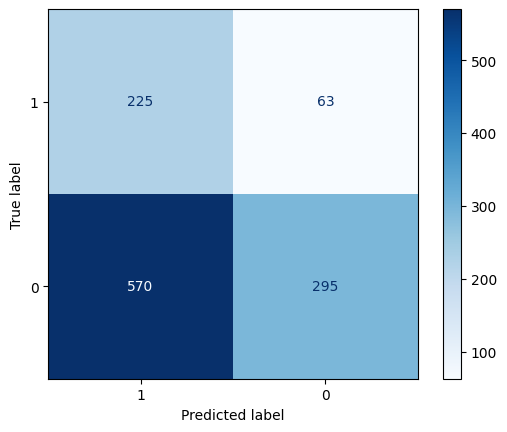

In [21]:
# Evaluate the Naive Bayes classifier on the test data
y_pred_nb, yhat_nb, fpr_nb, tpr_nb, auc_nb = inference(classifier_nb, x_test, y_test)

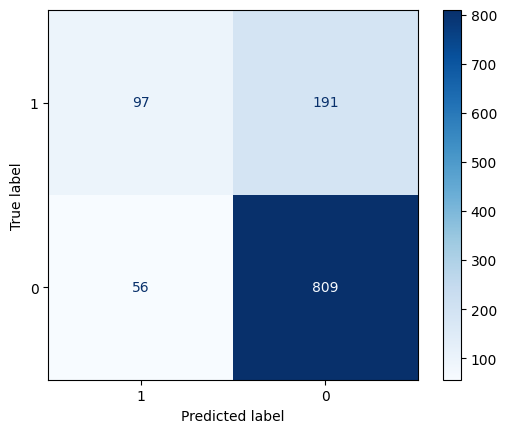

In [22]:
# Evaluate the Decision Tree classifier on the test data
y_pred_dt, yhat_dt, fpr_dt, tpr_dt, auc_dt = inference(classifier_dt, x_test, y_test)

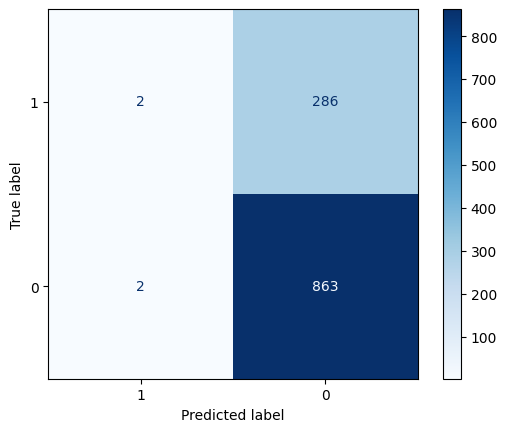

In [23]:
# Evaluate the K-Nearest Neighbors classifier on the test data
y_pred_knn, yhat_knn, fpr_knn, tpr_knn, auc_knn = inference(classifier_knn, x_test, y_test)

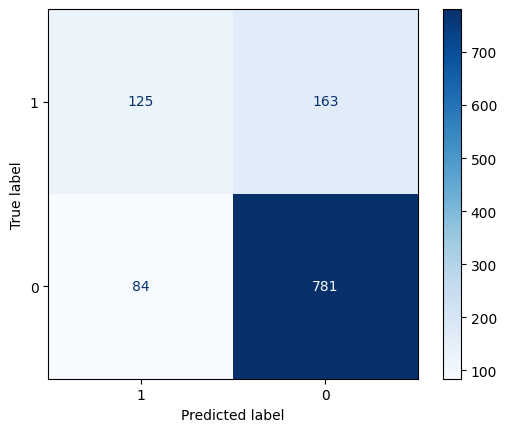

In [24]:
# Evaluate the Logistic Regression classifier on the test data
y_pred_lr, yhat_lr, fpr_lr, tpr_lr, auc_lr = inference(classifier_lr, x_test, y_test)

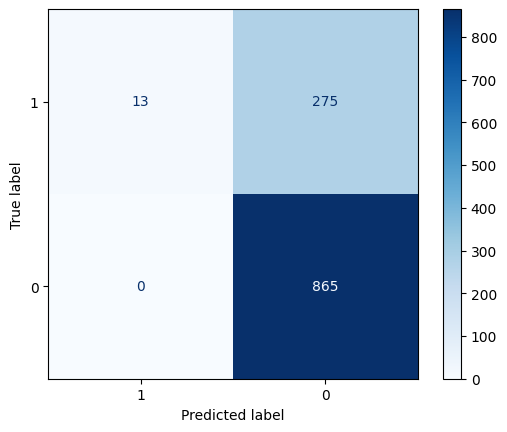

In [25]:
# Evaluate the Random Forest classifier on the test data
y_pred_rf, yhat_rf, fpr_rf, tpr_rf, auc_rf = inference(classifier_rf, x_test, y_test)

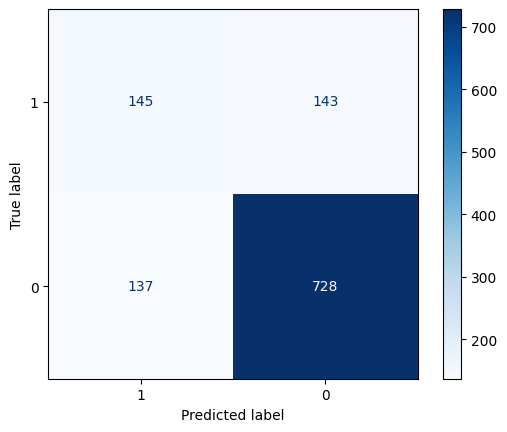

In [26]:
# Evaluate the SVM classifier on the test data
y_pred_svm, yhat_svm, fpr_svm, tpr_svm, auc_svm = inference(classifier_svm, x_test, y_test)

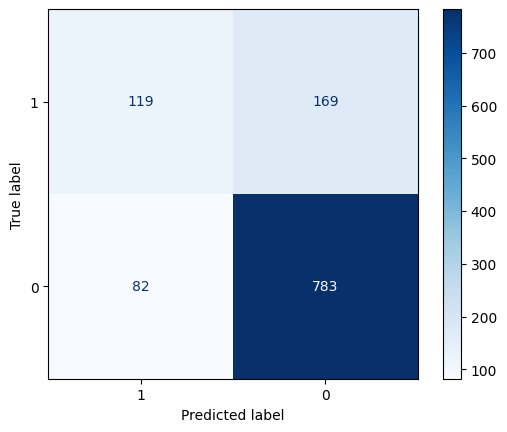

In [27]:
# Evaluate the Random Forest classifier on the test data
y_pred_ada, yhat_ada, fpr_ada, tpr_ada, auc_ada = inference(classifier_ada, x_test, y_test)

### Detailed Metrics for Evaluation

In [28]:
print("------- Machine Learning Results -------")
rf_score = accuracy_score(y_test, y_pred_rf)
knn_score = accuracy_score(y_test, y_pred_knn)
lr_score = accuracy_score(y_test, y_pred_lr)
dt_score = accuracy_score(y_test, y_pred_dt)
np_score = accuracy_score(y_test, y_pred_nb)
svm_score = accuracy_score(y_test, y_pred_svm)
ada_score = accuracy_score(y_test, y_pred_ada)

print ('--' * 20)
print('Random Forest Accuracy: ', str(rf_score))
print('F1 score: ', f1_score(y_test, y_pred_rf, labels = [1,0]))
print ('--' * 20)
print ('')
print ('--' * 20)
print('K-Nearest Neighbors Accuracy: ', str(knn_score))
print('F1 score: ', f1_score(y_test, y_pred_knn, labels = [1,0]))
print ('--' * 20)
print ('')
print ('--' * 20)
print('Logistic Regression Accuracy: ',str(lr_score))
print('F1 score: ', f1_score(y_test, y_pred_lr, labels = [1,0]))
print ('--' * 20)
print ('')
print ('--' * 20)
print('Decision Tree Accuracy: ', str(dt_score))
print('F1 score: ', f1_score(y_test, y_pred_dt, labels = [1,0]))
print ('--' * 20)
print ('')
print ('--' * 20)
print('Naive Bayes Accuracy: ', str(np_score))
print('F1 score: ', f1_score(y_test, y_pred_nb, labels = [1,0]))
print ('--' * 20)
print ('')
print ('--' * 20)
print('SVM Accuracy: ', str(svm_score))
print('F1 score: ', f1_score(y_test, y_pred_svm, labels = [1,0]))
print ('--' * 20)
print ('')
print ('--' * 20)
print('AdaBoost Accuracy: ', str(ada_score))
print('F1 score: ', f1_score(y_test, y_pred_ada, labels = [1,0]))
print ('--' * 20)

------- Machine Learning Results -------
----------------------------------------
Random Forest Accuracy:  0.7614917606244579
F1 score:  0.08637873754152824
----------------------------------------

----------------------------------------
K-Nearest Neighbors Accuracy:  0.7502168256721596
F1 score:  0.0136986301369863
----------------------------------------

----------------------------------------
Logistic Regression Accuracy:  0.7857762359063313
F1 score:  0.5030181086519114
----------------------------------------

----------------------------------------
Decision Tree Accuracy:  0.7857762359063313
F1 score:  0.4399092970521542
----------------------------------------

----------------------------------------
Naive Bayes Accuracy:  0.45099739809193407
F1 score:  0.4155124653739612
----------------------------------------

----------------------------------------
SVM Accuracy:  0.7571552471812663
F1 score:  0.5087719298245614
----------------------------------------

---------------

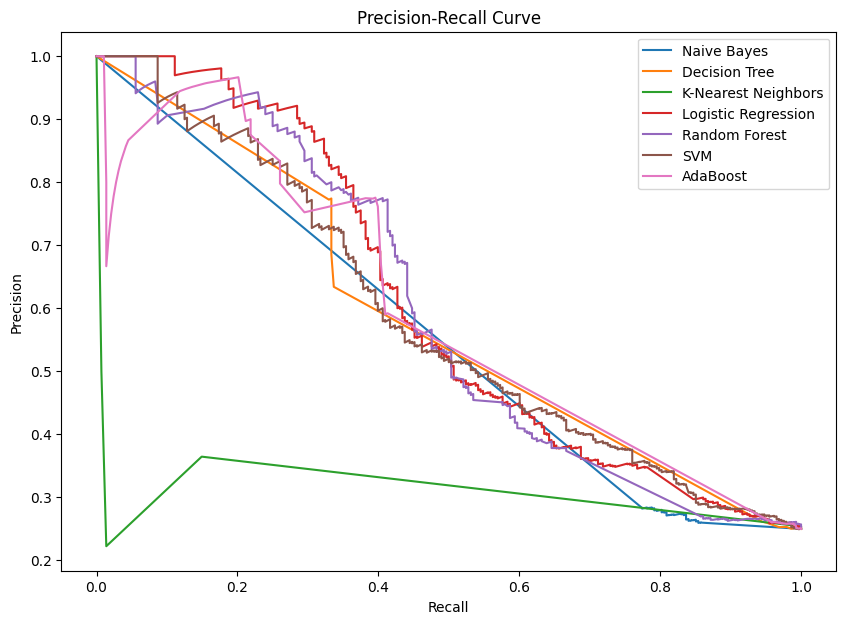

In [29]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Get prediction scores for each classifier (use `predict_proba` if available, or `decision_function` if it's an SVM)
y_scores_np = classifier_nb.predict_proba(x_test)[:, 1]
y_scores_dt = classifier_dt.predict_proba(x_test)[:, 1]
y_scores_knn = classifier_knn.predict_proba(x_test)[:, 1]
y_scores_lr = classifier_lr.predict_proba(x_test)[:, 1]
y_scores_rf = classifier_rf.predict_proba(x_test)[:, 1]
y_scores_svm = classifier_svm.decision_function(x_test)
y_scores_ada = classifier_ada.predict_proba(x_test)[:, 1]

# Calculate precision-recall values
prec_np, rec_np, _ = precision_recall_curve(y_test, y_scores_np)
prec_dt, rec_dt, _ = precision_recall_curve(y_test, y_scores_dt)
prec_knn, rec_knn, _ = precision_recall_curve(y_test, y_scores_knn)
prec_lr, rec_lr, _ = precision_recall_curve(y_test, y_scores_lr)
prec_rf, rec_rf, _ = precision_recall_curve(y_test, y_scores_rf)
prec_svm, rec_svm, _ = precision_recall_curve(y_test, y_scores_svm)
prec_ada, rec_ada, _ = precision_recall_curve(y_test, y_scores_ada)

# Plot Precision-Recall curves
plt.figure(figsize=(10, 7))
plt.plot(rec_np, prec_np, label="Naive Bayes")
plt.plot(rec_dt, prec_dt, label="Decision Tree")
plt.plot(rec_knn, prec_knn, label="K-Nearest Neighbors")
plt.plot(rec_lr, prec_lr, label="Logistic Regression")
plt.plot(rec_rf, prec_rf, label="Random Forest")
plt.plot(rec_svm, prec_svm, label="SVM")
plt.plot(rec_ada, prec_ada, label="AdaBoost")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

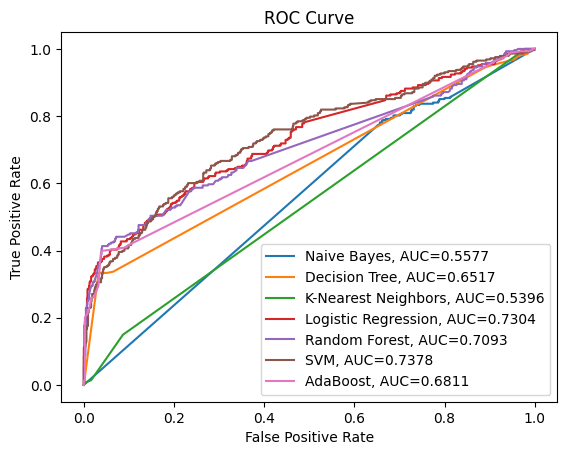

In [30]:
plt.plot(fpr_nb,tpr_nb,label="Naive Bayes, AUC="+str(auc_nb))
plt.plot(fpr_dt,tpr_dt,label="Decision Tree, AUC="+str(auc_dt))
plt.plot(fpr_knn,tpr_knn,label="K-Nearest Neighbors, AUC="+str(auc_knn))
plt.plot(fpr_lr,tpr_lr,label="Logistic Regression, AUC="+str(auc_lr))
plt.plot(fpr_rf,tpr_rf,label="Random Forest, AUC="+str(auc_rf))
plt.plot(fpr_svm,tpr_svm,label="SVM, AUC="+str(auc_svm))
plt.plot(fpr_ada,tpr_ada,label="AdaBoost, AUC="+str(auc_ada))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')

#add legend
plt.legend()

### Inference Using Saved ML-Based Model

In [16]:
import joblib
from sklearn.metrics import classification_report, accuracy_score

# Load the saved model
model = joblib.load('model_svm.pkl')

# Predict on the test set
y_pred = model.predict(x_test)

# Evaluate the predictions
print("Accuracy:", accuracy_score(test['label'], y_pred))
print("\nClassification Report:\n", classification_report(test['label'], y_pred))

Accuracy: 0.7571552471812663

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.84      0.84       865
           1       0.51      0.50      0.51       288

    accuracy                           0.76      1153
   macro avg       0.68      0.67      0.67      1153
weighted avg       0.76      0.76      0.76      1153

